# Model Rekomondasi

### Persiapaan Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack


In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y
    
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [3]:
df = pd.read_csv('sentiment_5400.csv')
df.head(10)

,content,sentimen
0,bogor keluarga fw 22 perempuan dibunuh pacarny...,negatif
1,khoiri 52 warga dusun blimbing desa parerejo k...,negatif
2,polisi menangkap andrea cw inggris chansler am...,negatif
3,wakil ketua umum pan yandri susanto capres ani...,negatif
4,pria medan satria kota bekasi terluka lehernya...,negatif
5,kpu ri menilai surat suara taipei taiwan surat...,negatif
6,jet jet tempur israel melancarkan serangan uda...,negatif
7,rumah milik mf 16 remaja diduga mencekik bocah...,negatif
8,calon presiden ganjar pranowo relawannya ikuta...,negatif
9,calon wakil presiden cawapres nomor urut 1 muh...,negatif


In [4]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)


In [5]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]


In [6]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

# Bag of Words (BoW) features
count_vectorizer, count_train_features = bow_extractor(x_train)
count_test_features = count_vectorizer.transform(x_test)

# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

In [7]:
# TF-IDF Features
print("Jumlah fitur TF-IDF:", tfidf_train_features.shape[1])

# Bag of Words (BoW) Features
print("Jumlah fitur Bag of Words:", count_train_features.shape[1])

# Combined Features
print("Jumlah fitur gabungan:", combined_train_features.shape[1])

Jumlah fitur TF-IDF: 245316
Jumlah fitur Bag of Words: 26266
Jumlah fitur gabungan: 271582


### Model Naiye Bayes

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    # Classification report
    report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
    
    # Confusion matrix
    matrix = confusion_matrix(test_labels, predictions)
    
    return accuracy * 100, f1 * 100, report, matrix

In [10]:
# Function to plot confusion matrix
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#### Tanpa Parameter

In [11]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1, tfidf_report, tfidf_matrix = train_and_evaluate(model_naiye_tanpa_parameter, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1, bow_report, bow_matrix = train_and_evaluate(model_naiye_tanpa_parameter, count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1, combined_report, combined_matrix = train_and_evaluate(model_naiye_tanpa_parameter, combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

In [12]:
print("TF-IDF Vectorization:")
print("Accuracy: {:.2f}%".format(tfidf_accuracy))
print("F1 Score: {:.2f}%".format(tfidf_f1))
print("Classification Report:\n", tfidf_report)
print("Confusion Matrix:\n", tfidf_matrix)

TF-IDF Vectorization:
Accuracy: 77.96%
F1 Score: 77.72%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.81      0.70      0.75       575
      netral       0.82      0.72      0.77       508
     positif       0.73      0.92      0.82       537

    accuracy                           0.78      1620
   macro avg       0.79      0.78      0.78      1620
weighted avg       0.79      0.78      0.78      1620

Confusion Matrix:
 [[401  58 116]
 [ 76 368  64]
 [ 21  22 494]]


In [13]:
print("\nBag of Words (BoW) features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)


Bag of Words (BoW) features:
Accuracy: 78.27%
F1 Score: 78.07%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.80      0.74      0.77       575
      netral       0.85      0.69      0.76       508
     positif       0.72      0.92      0.81       537

    accuracy                           0.78      1620
   macro avg       0.79      0.78      0.78      1620
weighted avg       0.79      0.78      0.78      1620

Confusion Matrix:
 [[427  42 106]
 [ 78 348  82]
 [ 26  18 493]]


In [14]:
print("\nCombined TF-IDF and BoW features:")
print("Accuracy: {:.2f}%".format(combined_accuracy))
print("F1 Score: {:.2f}%".format(combined_f1))
print("Classification Report:\n", combined_report)
print("Confusion Matrix:\n", combined_matrix)


Combined TF-IDF and BoW features:
Accuracy: 76.17%
F1 Score: 75.68%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.79      0.75      0.77       575
      netral       0.92      0.57      0.71       508
     positif       0.67      0.95      0.79       537

    accuracy                           0.76      1620
   macro avg       0.79      0.76      0.76      1620
weighted avg       0.79      0.76      0.76      1620

Confusion Matrix:
 [[434  22 119]
 [ 89 291 128]
 [ 24   4 509]]


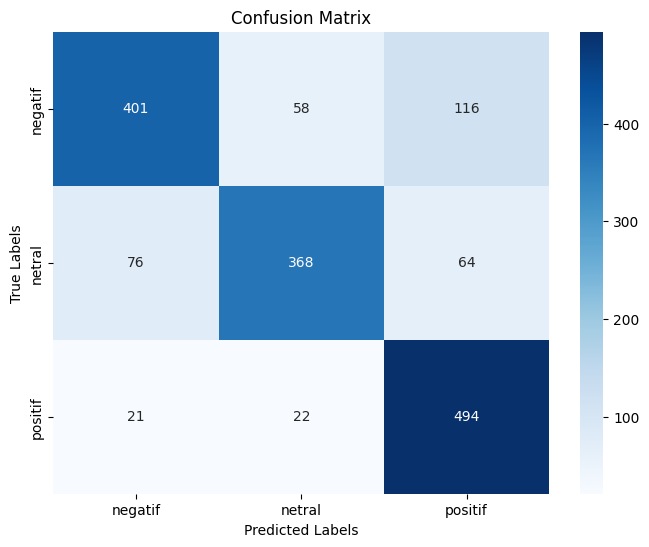

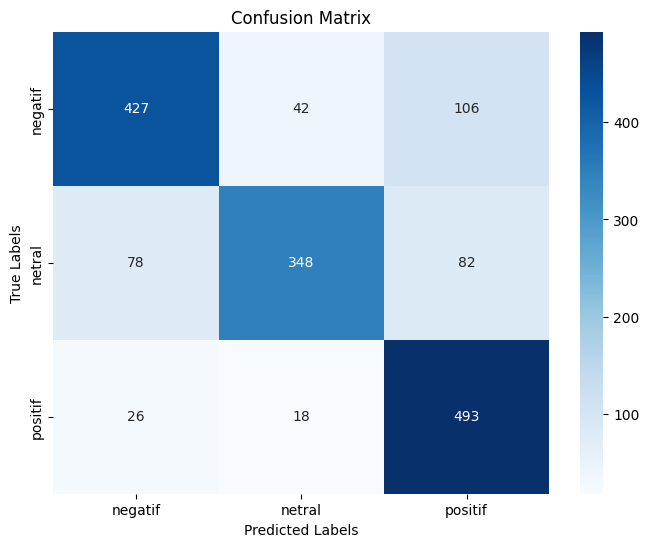

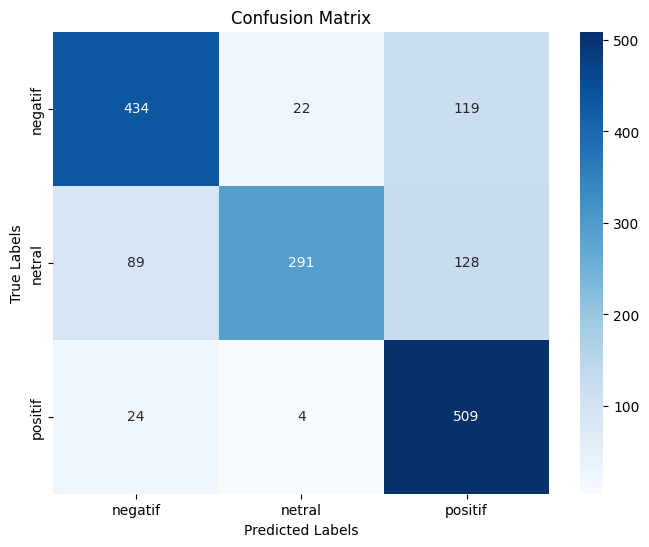

In [15]:
# Plot confusion matrix
plot_confusion_matrix(tfidf_matrix, label_encoder.classes_)
plot_confusion_matrix(bow_matrix, label_encoder.classes_)
plot_confusion_matrix(combined_matrix, label_encoder.classes_)

In [22]:
test = ('Jeka Saragih On Fire Menatap Debut di UFC dengan menang secara telak')
test_sentence_features = hstack([tfidf_vectorizer.transform([test]), count_vectorizer.transform([test])])
test_result = model_naiye_tanpa_parameter.predict(test_sentence_features)
# Konversi kembali label prediksi ke label teks
predicted_label = label_encoder.inverse_transform(test_result)

# Tampilkan hasil prediksi dalam bentuk kategori
print("Hasil Prediksi (dengan fitur kombinasi):", predicted_label)

Hasil Prediksi (dengan fitur kombinasi): ['positif']


#### Tuning

In [26]:
# Tentukan parameter grid yang akan dieksplorasi
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],  # Parameter alpha untuk smoothing
    'fit_prior': [True, False]            # Opsional, apakah akan mempelajari probabilitas prior atau tidak
}

# Buat objek GridSearchCV
grid_search = GridSearchCV(model_naiye_tanpa_parameter, param_grid, cv=5, scoring='accuracy')

# Lakukan fitting terhadap data pelatihan
grid_search.fit(tfidf_train_features, y_train_encoded)

# Dapatkan parameter terbaik dan skor terbaik
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluasi model dengan parameter terbaik
best_model = grid_search.best_estimator_
accuracy, f1, _, _ = train_and_evaluate(best_model, tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)
print("Best Parameters:", best_model)
print("Accuracy (Best Model):", accuracy)
print("F1 Score (Best Model):", f1)

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best Score: 0.7984126984126985
Best Parameters: MultinomialNB(alpha=0.1)
Accuracy (Best Model): 79.75308641975309
F1 Score (Best Model): 79.59697593897329


#### Pakai Paramater

### Model SVM

### Model Logistic Regression

### Model Random Forest

### Model Ensemble Learning